# Hindi to English Transliteration using Sequence to Sequence models

The purpose of this notebook is as follows:

- Use the Dakshini dataset to get Hindi and English word data for transliteration. A sample of the data is as below
```
अंकगणित	ankganit	3
अंकल	uncle	4
अंकुर	ankur	4
```
- Create an Encoder-Decoder setup using Pytorch which will be trained on the corpus and tested similarly
- Use Encoder-Decoder with Attention and check performance in comparison to without attention




In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
import random

try:
  import pytorch_lightning as pl
except:
  !pip install --quiet pytorch-lightning>=1.5
  import pytorch_lightning as pl

In [ ]:
# mat1 = torch.rand((128,20,128))
# mat2 = torch.rand((128,1,128))

# mat3 = mat1+mat2
# print(mat3.shape)

In [ ]:
mat1 = torch.rand((128,20,1))
mat1 = mat1.squeeze(2).unsqueeze(1)
mat1.shape

torch.Size([128, 1, 20])

In [ ]:
# mat = torch.rand((32,10,128))

In [ ]:
# mat.shape

In [ ]:
# mat = mat.permute(1,0,2)
# mat.shape

In [ ]:
# a = torch.rand(2,3)
# print(a)


In [ ]:
# b = torch.rand(3)
# print(b)

In [ ]:
# a+b

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  random.seed(seed)

set_seed(132)


#Get the dataset


In [ ]:
!wget https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar

--2024-05-18 08:14:16--  https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.207, 142.251.10.207, 142.251.12.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2008340480 (1.9G) [application/x-tar]
Saving to: ‘dakshina_dataset_v1.0.tar’

dakshina_dataset_v1 100%[===================>]   1.87G  21.2MB/s    in 1m 50s  

2024-05-18 08:16:07 (17.4 MB/s) - ‘dakshina_dataset_v1.0.tar’ saved [2008340480/2008340480]



In [ ]:
!tar -xf '/content/dakshina_dataset_v1.0.tar'

VAL_PATH = '/content/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv'
TRAIN_PATH = '/content/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv'
TEST_PATH = '/content/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv'

train_df = pd.read_csv(TRAIN_PATH, sep='\t', names=['Hindi', 'English', ''])
val_df = pd.read_csv(VAL_PATH, sep='\t', names=['Hindi', 'English', ''])
test_df = pd.read_csv(TEST_PATH, sep='\t', names=['Hindi', 'English', ''])

In [ ]:
train_df.head(5)

,Hindi,English,
0,अं,an,3
1,अंकगणित,ankganit,3
2,अंकल,uncle,4
3,अंकुर,ankur,4
4,अंकुरण,ankuran,3


In [ ]:
print(f'Train data shape : {train_df.shape}')
print(f'Val data shape : {val_df.shape}')
print(f'Test data shape : {test_df.shape}')

Train data shape : (44204, 3)
Val data shape : (4358, 3)
Test data shape : (4502, 3)


In [ ]:
#To tackle a problematic case of नं	-> nan
train_df.fillna('naan', inplace=True)
val_df.fillna('naan', inplace=True)
test_df.fillna('naan', inplace=True)

In [ ]:
train_df.isna().any()

Hindi      False
English    False
           False
dtype: bool

Create class 'LangProcess' which will take the language name and its words, and create an object which holds the information required for mapping the language words to its respective and other information related to the corpus.

In [ ]:
class LangProcess():
  def __init__(self, lang_name, lang_data):
    '''
    lang_name : Name of the language
    lang_data : Data for this language (words)
    '''
    self.lang_name = lang_name
    self.char_to_idx = {'SOS':0, 'EOS':1}
    self.idx_to_char = {0:'SOS', 1:'EOS'}
    self.char_count = {}
    self.chars_size = 2
    self.chars = ['SOS', 'EOS']
    self.max_input_len = 1 #Including EOS

    for word in lang_data:
      if (len(word)+1)>self.max_input_len:
        self.max_input_len = len(word)+1
      self.add_char(word)

  def add_char(self, word):
    #NOTE : If word is 'nan', it is identified by pandas as Nan
    #However it is actually index 19536 ie नं	nan
    #Tackling it manually
    for char in word:
      if char in self.char_to_idx.keys():
        #Character already in corpus, simply increment count
        self.char_count[char] += 1
      else:
        self.char_to_idx[char] = self.chars_size
        self.idx_to_char[self.chars_size] = char
        self.char_count[char] = 1
        self.chars_size += 1
        self.chars.append(char)

  def indices_to_word(self, indices):
    word = ""
    for i in indices:
      if i==0 or i==1:
        break
      word += self.idx_to_char[i]
    return word

In [ ]:
input_lang = LangProcess('Hindi', train_df['Hindi'])
output_lang = LangProcess('English', train_df['English'])

In [ ]:
def display_stats(lang_obj):
  print(f"For Language : {lang_obj.lang_name}")
  print(f"Corpus char - index mapping : {lang_obj.char_to_idx}")
  print(f"Character size : {lang_obj.chars_size}")
  print(f"Max input size : {lang_obj.max_input_len}")

display_stats(input_lang)
print("*********************************")
display_stats(output_lang)

For Language : Hindi
Corpus char - index mapping : {'SOS': 0, 'EOS': 1, 'अ': 2, 'ं': 3, 'क': 4, 'ग': 5, 'ण': 6, 'ि': 7, 'त': 8, 'ल': 9, 'ु': 10, 'र': 11, 'श': 12, 'द': 13, 'न': 14, 'े': 15, 'भ': 16, '्': 17, 'ष': 18, 'ा': 19, 'ी': 20, 'ठ': 21, 'य': 22, 'ो': 23, 'ू': 24, 'ज': 25, 'च': 26, 'म': 27, 'ट': 28, 'ड': 29, 'व': 30, 'ः': 31, 'ह': 32, 'प': 33, 'ृ': 34, 'स': 35, 'ध': 36, 'ै': 37, '़': 38, 'ब': 39, 'उ': 40, 'ॉ': 41, 'ई': 42, 'ख': 43, 'घ': 44, 'छ': 45, 'ञ': 46, 'फ': 47, 'ओ': 48, 'थ': 49, 'ढ': 50, 'झ': 51, 'ौ': 52, 'आ': 53, 'इ': 54, 'ँ': 55, 'ए': 56, 'ऊ': 57, 'ॅ': 58, 'ऋ': 59, 'ऑ': 60, 'ऐ': 61, 'औ': 62, 'ङ': 63, 'ॐ': 64}
Character size : 65
Max input size : 20
*********************************
For Language : English
Corpus char - index mapping : {'SOS': 0, 'EOS': 1, 'a': 2, 'n': 3, 'k': 4, 'g': 5, 'i': 6, 't': 7, 'u': 8, 'c': 9, 'l': 10, 'e': 11, 'r': 12, 's': 13, 'h': 14, 'd': 15, 'b': 16, 'y': 17, 'o': 18, 'j': 19, 'z': 20, 'm': 21, 'v': 22, 'w': 23, 'p': 24, 'f': 25, 'x': 26, 'q':

Now, we need to write utility functions to process the input words as as sequence of numbers, based on the character to index mapping. Thus, we would have 2 lists, one for hindi and for english, containing the numeric representation for the words based on character indices.

In [ ]:
def create_word_vector(lang_obj, word):
  word_mapped = [lang_obj.char_to_idx[char] for char in word]
  return word_mapped

def create_dataloader(data_df = train_df, batch_size=128, shuffle=True):

  data_len = data_df.shape[0]
  print(f"Processing {data_len} entries.....")

  #Initialize a 0 vector for each entry of training input and output data (zero padding the extra values considering max seq length)
  input_data = np.zeros((data_len, input_lang.max_input_len), dtype=np.int32)
  output_data = np.zeros((data_len, output_lang.max_input_len), dtype=np.int32)

  input_words = data_df['Hindi']
  output_words = data_df['English']

  for idx, (input_w, output_w) in enumerate(zip(input_words, output_words)):
    input_indices = create_word_vector(input_lang, input_w)
    output_indices = create_word_vector(output_lang, output_w)

    input_indices.append(input_lang.char_to_idx['EOS'])
    output_indices.append(output_lang.char_to_idx['EOS'])

    input_data[idx,:len(input_indices)] = input_indices
    output_data[idx,:len(output_indices)] = output_indices

  #Now all processing and conversion of words to sequence of char indices is done
  #Proceed with torch Dataset and DataLoader creation
  #TODO:Dataset and Dataloader

  dataset = TensorDataset(
      torch.LongTensor(input_data),
      torch.LongTensor(output_data)
      )

  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=4)

  return dataloader



In [ ]:
train_dataloader = create_dataloader(train_df, 128, True)
val_dataloader = create_dataloader(val_df, 128, False)
test_dataloader = create_dataloader(test_df, 128, False)

Processing 44204 entries.....
Processing 4358 entries.....
Processing 4502 entries.....


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
#CUDA_LAUNCH_BLOCKING=0

In [ ]:
next(iter(train_dataloader))[1].shape

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([128, 21])

In [ ]:
next(iter(train_dataloader))[1].view(-1, ).shape

torch.Size([2688])

## Encoder - Decoder architecture using Pytorch

In the section below, the Pytorch based classes for the Encoder and Decoder layers would be structured to allow the model training for the dataset. The Encoder layers would create the Context vector (the final hidden layer value), which would be passed over to the Decoder as the initial hidden state. An attention based architecture would also be used later.


In [ ]:
class Encoder(nn.Module):
  def __init__(self, input_size, hidden_size, dropout=0.1):
    super().__init__()
    self.hidden_size = hidden_size
    #Below module will convert a word of n chars (ie sequence of n char indices) to n vectors of size hdden_size
    # inp = torch.LongTensor([1,12,32])
    # emb = nn.Embedding(33, 5)
    # tensor([[ 1.0509, -0.6933, -1.6445,  0.4131,  1.0456],
    #   [ 0.0117, -0.8146,  0.3862, -0.7615,  0.5252],
    #   [ 1.1112, -0.6562, -0.8455, -1.5215,  1.4525]],
    #  grad_fn=<EmbeddingBackward0>)
    self.embedding = nn.Embedding(input_size, hidden_size)
    self.GRU = nn.GRU(hidden_size, hidden_size, batch_first=True) #indication that the first dimension would be batch_size
    self.dropout = nn.Dropout(p=dropout)

  def forward(self, input):
    #1. Embed the input vector of n indexes -> n vectors of vector (each of hidden_size) ie (n,hidden_size)
    #2. Pass this through dropout (reglarization)
    #3. Now, pass this sequence of inputs to the GRU, to get output and final hidden state (sequences are managed internally)
    embedded = self.dropout(self.embedding(input))
    output, hidden = self.GRU(embedded)

    return output, hidden



In [ ]:
class Decoder(nn.Module):
  def __init__(self, output_size, hidden_size, dropout=0.1):

    super().__init__()
    self.hidden_size = hidden_size
    self.embedding = nn.Embedding(output_size, hidden_size)
    self.GRU = nn.GRU(hidden_size, hidden_size, batch_first = True)
    self.linear = nn.Linear(hidden_size, output_size)
    self.dropout = nn.Dropout(dropout)

  def forward(self, encoder_output, hidden, target_outputs=None):
    #The decoder gets the hidden state of the last encoder (ie. context vector) and the batch of decoder target inputs
    #Initially, we pass the batch's first input token as the SOS token
    #Then, during training, teacher forcing is used (original output token passed as next input)

    batch_size  = encoder_output.shape[0]
    decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(output_lang.char_to_idx['SOS'])
    decoder_hidden = hidden
    decoder_outputs = []

    for idx in range(output_lang.max_input_len):
      decoder_output, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)
      decoder_outputs.append(decoder_output)

      #In training phase, target outputs will be passed. This is used to track if teacher forcing should be used or not
      if target_outputs is not None:
        #Teacher forcing
        decoder_input = target_outputs[:,idx].unsqueeze(1)
      else:
        #Use decoder previous output as new input during inference
        #top_indices holds the largest prob value index for next output token (per input of the batch)
        #https://stackoverflow.com/questions/57237352/what-does-unsqueeze-do-in-pytorch
        top_vals, top_indices = decoder_output.topk(1)
        decoder_input = top_indices.squeeze(-1).detach()

    #print(f"decoder_outputs dim before : {len(decoder_outputs)} x {decoder_outputs[0].shape}")
    #decoder_outputs dim before : 21 x torch.Size([128, 1, 28])
    decoder_outputs = torch.cat(decoder_outputs, dim=1)
    #print(f"decoder_outputs dim after : {len(decoder_outputs)} x {decoder_outputs[0].shape}")
    #decoder_outputs dim after : 128 x torch.Size([21, 28])
    decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
    #print(f"decoder_outputs dim post softmax : {len(decoder_outputs)} x {decoder_outputs[0].shape}")
    #decoder_outputs dim post softmax : 128 x torch.Size([21, 28])

    return decoder_outputs, decoder_hidden, None #Added extra none because while using attention, we'll pass attention weights

  def forward_step(self, input, hidden):
      embedded = self.embedding(input)
      embedded = F.relu(embedded)
      output, hidden = self.GRU(embedded, hidden)
      output = self.linear(output)
      return output, hidden

## Creating Training related functionalities

In [ ]:
def train_epoch(dataloader, encoder, decoder, loss_fn, encoder_optimizer, decoder_optimizer):

  #For each batch of data:
  #1. Pass data, labels to device (already done in dataloader)
  #2. Pass data to encoder, get outputs, hidden
  #3. Pass data to decoder, get predictions for batch
  #4. Set gradient to 0 for optimizer(encoder and decoder)
  #5. Compute loss
  #6. loss backward pass
  #7. Optimizer step (encoder and decoder)
  #8. Increment the total loss with the loss for this batch
  # After all loops, return aggregate loss for this epoch

  total_loss = []

  for batch in dataloader:
    data, target = batch

    data = data.to(device)
    target = target.to(device)

    encoder_output, encoder_hidden = encoder(data)
    decoder_output, decoder_hidden, _ = decoder(encoder_output, encoder_hidden, target)

    # print(f"Shape in loss : {decoder_output.shape}")
    # print(f"Dim preds : {decoder_output.view(-1, decoder_output.size(-1)).shape}")
    # print(f"Dim labels : {target.view(-1).shape}")

    #Dim labels : torch.Size([2688]) where 2688 = 128*21 (Batch size*max word length)
    #Dim preds : torch.Size([2688, 28])
    loss = loss_fn(
        decoder_output.view(-1, decoder_output.size(-1)),
        target.view(-1)
    )

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    total_loss.append(loss.item())

  return sum(total_loss)/len(total_loss)


In [ ]:
def train(encoder, decoder, encoder_optimizer, decoder_optimizer, loss_fn, epochs = 10):

  for e in range(epochs):
    loss = train_epoch(train_dataloader, encoder, decoder, loss_fn, encoder_optimizer, decoder_optimizer)
    print(f"Epoch {e} : Loss {loss}")



In [ ]:
hidden_size = 128
learning_rate = 0.01

encoder = Encoder(input_lang.chars_size, hidden_size).to(device)
decoder = Decoder(output_lang.chars_size, hidden_size).to(device)

encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

train(encoder, decoder, encoder_optimizer, decoder_optimizer, loss_fn, epochs=10)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 0 : Loss 0.5638245147776741
Epoch 1 : Loss 0.330467631448211
Epoch 2 : Loss 0.2822112492743255
Epoch 3 : Loss 0.25825673350364486
Epoch 4 : Loss 0.2421217335528032
Epoch 5 : Loss 0.2307418474141573
Epoch 6 : Loss 0.2248903665411679
Epoch 7 : Loss 0.21667454219450152
Epoch 8 : Loss 0.21285596937802487
Epoch 9 : Loss 0.20875625101300332


In [ ]:
def test(encoder, decoder, loss_fn, dataloader):

  overall_loss = []
  with torch.no_grad():
    for data in dataloader:
      input, target = data
      input = input.to(device)
      target = target.to(device)

      encoder_output, encoder_hidden = encoder(input)
      decoder_output, _, _ = decoder(encoder_output, encoder_hidden)

      loss = loss_fn(
        decoder_output.view(-1, decoder_output.size(-1)),
        target.view(-1)
      )

      overall_loss.append(loss.item())

      #Print 1 random input from batch along with its output and prediction
      idx = random.randint(0,input.shape[0]-1)
      input_indices = input[idx]
      target_indices = target[idx]
      pred_indices = []
      for i in range(len(decoder_output[idx])):
        pred_indices.append(torch.argmax(decoder_output[idx][i]).item())

      input_word = input_lang.indices_to_word(input_indices.tolist())
      target_word = output_lang.indices_to_word(target_indices.tolist())
      pred_word = output_lang.indices_to_word(pred_indices)
      print("***********************************")
      print(f"Input : {input_word}")
      print(f"Target : {target_word}")
      print(f"Pred : {pred_word}")
      print("***********************************")




In [ ]:
test(encoder, decoder, loss_fn, test_dataloader)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


***********************************
Input : अंतः
Target : antaha
Pred : antoh
***********************************
***********************************
Input : अवैज्ञानिक
Target : avaigyanic
Pred : avagyanik
***********************************
***********************************
Input : आवाज़ों
Target : aawajon
Pred : aavajon
***********************************
***********************************
Input : ईए
Target : ea
Pred : in
***********************************
***********************************
Input : एलर्जिक
Target : allergic
Pred : eliruci
***********************************
***********************************
Input : करपात्री
Target : karpatri
Pred : karapatri
***********************************
***********************************
Input : किल्लत
Target : killat
Pred : killat
***********************************
***********************************
Input : गांठों
Target : ganthon
Pred : ganthon
***********************************
***********************************
Input : चढ़ने
Ta

## Attention Based Encoder Decoder Architecture

The Bahdanau Attention mechanism would be used to ensure the Decoder can extract any relevant information from the encoder outputs based on certain learned attention weights.

###### NOTE 1: Encoder outputs are also called KEYS, Hidden state (prev) is also called QUERY

###### NOTE2: CHECK COMMENTS IN CODE BELOW TO SEE HOW AND WHY DIMENSIONS ARE MODIFIED

In [ ]:
class BahdanauAttention(nn.Module):
  def __init__(self, hidden_size):
    super().__init__()
    self.WA = nn.Linear(hidden_size, hidden_size)
    self.UA = nn.Linear(hidden_size, hidden_size)
    #We need 1 output value per encoder sequence output
    self.VA = nn.Linear(hidden_size, 1)

  def forward(self, encoder_outputs, hidden_input):
    # Encoder output shape : B,L,H
    # Hidden input shape : 1,B,H (Since only last hidden layer used for context vector)
    # B->Batch size, L->Sequence length of encoder input, H->Hidden layer size

    #Step 1: Modify the Hidden Input to have batch size on the outside (1 tensor of hidden size H)
    #Hence hidden_input_perm is of size B,1,H
    hidden_input_perm = hidden_input.permute(1,0,2)

    #Step 2: Since now both the encoder outputs and hidden input have H as their last dimension and B as their first, they can be passed
    #       to the WA and UA layers as the Batched inputs of size H

    out1 = self.WA(encoder_outputs)
    out2 = self.UA(hidden_input_perm)

    #Step 3: Merge the outputs from above and pass through tanh activation and Linear layer VA
    #Since the addition is at batch level, the dimensions would be B,L,H (as hidden input is of dim B,1,H)
    output = self.VA(torch.tanh(out1+out2))

    #The above output is also of size B,L,1
    #We need to logits for each each batch corresponsing the sequence length L
    #Hence we need to convert B,L,1 to B,1,L
    # 1. output.squeeze(2) --> B,L (removed the dim of size 1 at pos 2)
    # 2. output.unsqueeze(1) --> B,1,L (Converted the L tensors into a single tensor of size L)

    output = output.squeeze(2).unsqueeze(1)
    weights = F.softmax(output, dim=-1) #These are the attention weights

    #For a single batch, we have (1,L) dim tensor of att weights and (L,H) dim of encoder outputs
    #Perform a Matrix multiplication to get (1,H) dim vector, which has the context vector after applying attention
    #To perform at batch level, use torch.bmm
    #Dimension for context = (B,1,H)
    context = torch.bmm(weights, encoder_outputs)

    return weights, context

In [ ]:
class AttentionDecoder(nn.Module):
  def __init__(self, output_size, hidden_size, dropout=0.1):
    super().__init__()

    self.embedding = nn.Embedding(output_size, hidden_size)
    self.bahdanauAtt = BahdanauAttention(hidden_size)

    #Since we would have both the attention based encoder outputs (hidden_size) and decoder inputs(hidden_size) as GRU input
    self.GRU = nn.GRU(2*hidden_size, hidden_size, batch_first = True)
    self.linear = nn.Linear(hidden_size, output_size)
    self.dropout = nn.Dropout(dropout)

  def forward(self, encoder_output, hidden, target_outputs=None):
    #The decoder gets the hidden state of the last encoder (ie. context vector) and the batch of decoder target inputs
    #Initially, we pass the batch's first input token as the SOS token
    #Then, during training, teacher forcing is used (original output token passed as next input)

    batch_size  = encoder_output.shape[0]
    decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(output_lang.char_to_idx['SOS'])
    decoder_hidden = hidden
    decoder_outputs = []
    attention_ws = []

    for idx in range(output_lang.max_input_len):
      decoder_output, decoder_hidden, attention_weights = self.forward_step(decoder_input, decoder_hidden, encoder_output)
      decoder_outputs.append(decoder_output)
      attention_ws.append(attention_weights)

      #In training phase, target outputs will be passed. This is used to track if teacher forcing should be used or not
      if target_outputs is not None:
        #Teacher forcing
        decoder_input = target_outputs[:,idx].unsqueeze(1)
      else:
        #Use decoder previous output as new input during inference
        #top_indices holds the largest prob value index for next output token (per input of the batch)
        #https://stackoverflow.com/questions/57237352/what-does-unsqueeze-do-in-pytorch
        top_vals, top_indices = decoder_output.topk(1)
        decoder_input = top_indices.squeeze(-1).detach()

    #print(f"decoder_outputs dim before : {len(decoder_outputs)} x {decoder_outputs[0].shape}")
    #decoder_outputs dim before : 21 x torch.Size([128, 1, 28])
    #Concatenate each of the 21 tensors across dim 1
    decoder_outputs = torch.cat(decoder_outputs, dim=1)
    #print(f"decoder_outputs dim after : {len(decoder_outputs)} x {decoder_outputs[0].shape}")
    #decoder_outputs dim after : 128 x torch.Size([21, 28])
    decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
    #print(f"decoder_outputs dim post softmax : {len(decoder_outputs)} x {decoder_outputs[0].shape}")
    #decoder_outputs dim post softmax : 128 x torch.Size([21, 28])

    #print(f"att ws dim before : {len(attention_ws)} x {attention_ws[0].shape}")
    #att ws dim before : 21 x torch.Size([128, 1, 20])
    attention_ws = torch.concat(attention_ws, dim=1)
    #print(f"att ws dim after : {len(attention_ws)} x {attention_ws[0].shape}")
    #att ws dim after : 128 x torch.Size([21, 20])
    #Every of the size 1 tensor containing size 20 tensors were concatenated for the 21 seq length of decoder
    #Thus making the 21 tensors, each containing 20 dim tensors (for each batch, ie 128 batches)
    #HERE 21 --> Max input size of english and 20--> Max input size of Hindi

    return decoder_outputs, decoder_hidden, attention_ws

  def forward_step(self, input, hidden, encoder_outputs):
    embedded = self.embedding(input)

    attention_weights, attention_context = self.bahdanauAtt(encoder_outputs, hidden)

    gru_input = torch.cat([attention_context, embedded], dim=2)
    output, hidden = self.GRU(gru_input, hidden)
    output = self.linear(output)
    return output, hidden, attention_weights

In [ ]:
hidden_size = 128
learning_rate = 0.001

encoder = Encoder(input_lang.chars_size, hidden_size).to(device)
decoder = AttentionDecoder(output_lang.chars_size, hidden_size).to(device)

encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

train(encoder, decoder, encoder_optimizer, decoder_optimizer, loss_fn, epochs=10)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 0 : Loss 0.7988574568591366
Epoch 1 : Loss 0.25338900214158044
Epoch 2 : Loss 0.17410259818755133
Epoch 3 : Loss 0.15190292675198847
Epoch 4 : Loss 0.13918510822288563
Epoch 5 : Loss 0.13101693910325882
Epoch 6 : Loss 0.12493291073021172
Epoch 7 : Loss 0.12086365206134801
Epoch 8 : Loss 0.11619311655101748
Epoch 9 : Loss 0.11248582909475861


### Testing the sentences from test dataset

In [ ]:
test(encoder, decoder, loss_fn, test_dataloader)

***********************************
Input : अनुप्रयोगों
Target : anupryogon
Pred : anuprayogon
***********************************
***********************************
Input : अर्थ
Target : arth
Pred : arth
***********************************
***********************************
Input : आशंका
Target : ashanka
Pred : aashanka
***********************************
***********************************
Input : इनहेलेशन
Target : inhalation
Pred : inhelation
***********************************
***********************************
Input : एपीजे
Target : apj
Pred : apge
***********************************
***********************************
Input : कंकड़
Target : kankar
Pred : kankad
***********************************
***********************************
Input : कैथोलिकों
Target : kaetholikon
Pred : catholicon
***********************************
***********************************
Input : ख़ासतौर
Target : khaastaur
Pred : khastaur
***********************************
*********************************

### Plot Attention heatmaps for sample test words

We will choose 6 random words and plot attention heatmaps to see how the trained attention weights provide importances to input characters corresponding output characters

In [ ]:
import matplotlib.ticker as ticker
import matplotlib
from matplotlib.font_manager import FontProperties

plt.rc('axes', unicode_minus=False)


test_dataloader_single = create_dataloader(test_df, len(test_df), False)

def plot_attention(attention_weights, input, output):
  print(f"{list(input)} : {list(output)}")
  # fig = plt.figure()
  # ax = fig.add_subplot(111)
  # print(attention_weights.shape)
  #print(attention_weights.cpu().numpy())
  # cax = ax.matshow(attention_weights[0:len(list(output))][0:len(list(input))].cpu().numpy(), cmap='bone')
  # fig.colorbar(cax)

  # Set up axes
  # ax.set_xticklabels(list(input), rotation=90)
  # ax.set_yticklabels(list(output))
  attention_weights = attention_weights.cpu().numpy()
  final_att_mat = []
  for i in range(len(list(output))+1):
    final_att_mat.append(attention_weights[i][0:len(list(input))+1])


  # df_cm = pd.DataFrame(final_att_mat, index = list(output)+[' '], columns = list(input)+[' '])
  # #print(df_cm.head(10))
  # sns.heatmap(df_cm)

  # #sns.heatmap(attention_weights[0:len(list(output))][0:len(list(input))].cpu().numpy(), xticklabels=list(input), yticklabels=list(output))

  # # Show label at every tick
  # ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  # ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  # plt.show()


  fig, ax = plt.subplots()
  cax = ax.imshow(final_att_mat, cmap='bone')
  fig.colorbar(cax)

  ax.set_xticks(np.arange(len(list(input))+1))

  ax.set_yticks(np.arange(len(list(output))+1))

  ax.set_yticklabels(list(output)+['<eos>'], fontproperties = FontProperties(fname = '/content/drive/MyDrive/Colab projects/LLM related/Transformer from scratch/UVA DL tutorials code/nirmala (1).ttf'))

  ax.set_xticklabels(list(input)+['<eos>'], fontproperties = FontProperties(fname = '/content/drive/MyDrive/Colab projects/LLM related/Transformer from scratch/UVA DL tutorials code/nirmala (1).ttf'))

  ax.tick_params(labelsize = 15)
  ax.tick_params(axis = 'x', labelrotation =  45)
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  plt.show()

def plot_sample_attention_heatmap(encoder, decoder, dataloader, count=6):

  for data in dataloader:

    indices = random.sample(range(0,data[0].shape[0]-1), count)

    with torch.no_grad():
      input, target = data
      input = input.to(device)
      target = target.to(device)

      encoder_output, encoder_hidden = encoder(input)
      decoder_output, _, attention_weights = decoder(encoder_output, encoder_hidden)

      for index in indices:

        input_indices = input[index]
        target_indices = target[index]
        #Attention maps are [21,20] dim vectors
        pred_indices = []
        for i in range(len(decoder_output[index])):
          pred_indices.append(torch.argmax(decoder_output[index][i]).item())

        input_word = input_lang.indices_to_word(input_indices.tolist())
        target_word = output_lang.indices_to_word(target_indices.tolist())
        pred_word = output_lang.indices_to_word(pred_indices)
        plot_attention(attention_weights[index], input_word, pred_word)



Processing 4502 entries.....


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


['क', 'ा', 'र', '्', 'य', 'भ', 'ा', 'र'] : ['k', 'a', 'r', 'y', 'a', 'b', 'h', 'a', 'r']


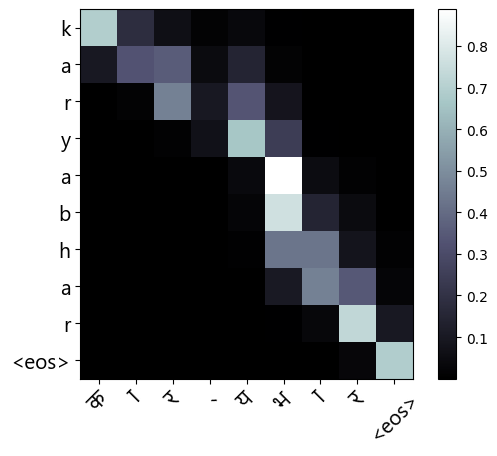

['स', 'ु', 'ज', 'े', 'न'] : ['s', 'u', 'j', 'e', 'n']


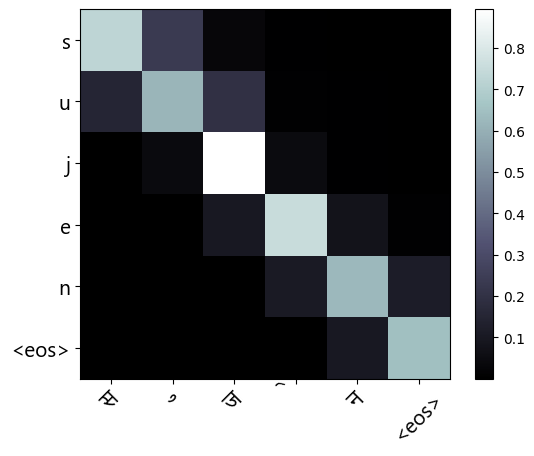

['न', 'ि', 'प', 'ट', 'ा', 'र', 'ा'] : ['n', 'i', 'p', 't', 'a', 'r', 'a']


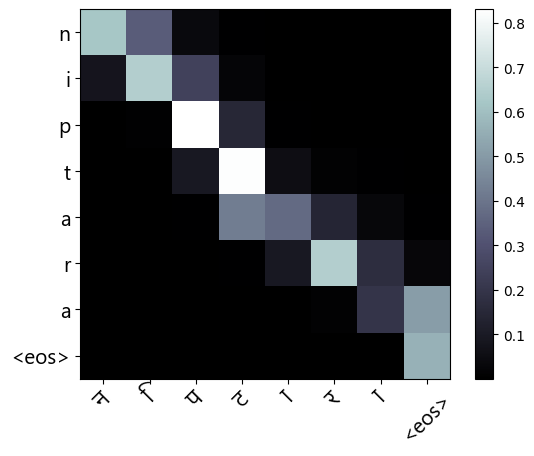

['च', 'ढ', '़', 'न', 'े'] : ['c', 'h', 'a', 'd', 'h', 'n', 'e']


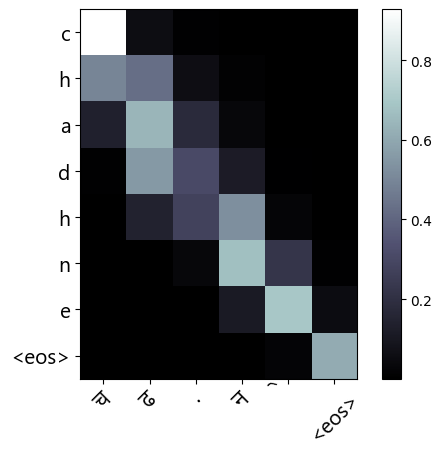

['फ', 'ी', 'ड', 'र'] : ['f', 'e', 'e', 'd', 'e', 'r']


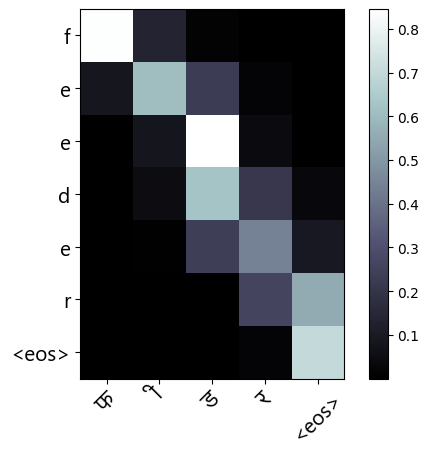

['म', 'े', 'ह', 'म', 'ा', 'न'] : ['m', 'e', 'h', 'm', 'a', 'n']


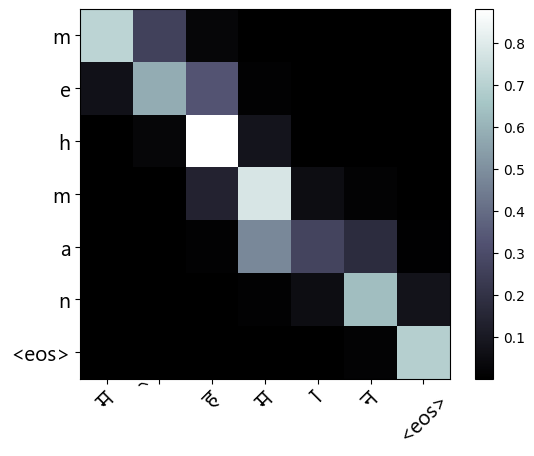

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
plot_sample_attention_heatmap(encoder, decoder, test_dataloader_single, count=6)